# Predicting Default for Credit Risk

In [21]:
import pandas as pd
import numpy as np
import sklearn
import plotnine as ggplot
import seaborn as sns
import matplotlib as mpl

In [22]:
credit_data = pd.read_csv("../DADOS/credit_risk_dataset.csv")

In [23]:
credit_data.shape

(32581, 12)

In [24]:
credit_data.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [25]:
credit_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


We can see that some features have missing values, such as *loan_percent_income* and *person_emp_length*

C:\Users\kioia\AppData\Local\Temp\ipykernel_1552\2833139563.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


<Axes: >

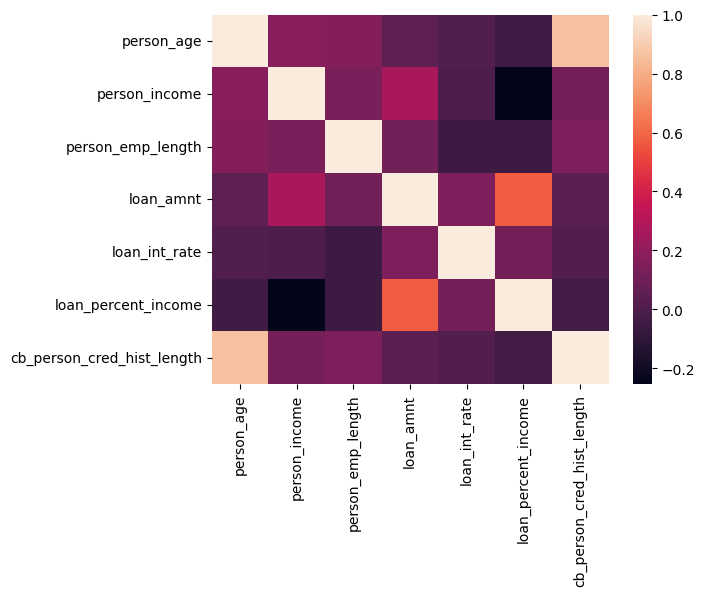

In [26]:
sns.heatmap(credit_data.drop(['loan_status'], axis = 1).corr())

In [27]:
from sklearn import model_selection
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn import linear_model
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, BaggingClassifier
from sklearn import naive_bayes
from sklearn import metrics

In [28]:
features = credit_data.drop({'loan_status'}, axis = 1)
target = credit_data['loan_status']

scores_metrics = []

train_x, validation_x, train_y, validation_y = model_selection.train_test_split(features, target, test_size = 0.3, random_state = 1234) 

In [29]:
categorical_features = list(train_x.select_dtypes(include = 'object').columns.tolist())
numerical_features = list(train_x.select_dtypes(exclude = 'object').columns.tolist())

categorical_features_index = [train_x.columns.get_loc(col) for col in categorical_features]
numerical_features_index = [train_x.columns.get_loc(col) for col in numerical_features]

In [30]:
num_pipeline = Pipeline([
    ('num_input', SimpleImputer(strategy='median')),
    ('Strd', StandardScaler())
])

cat_pipeline = Pipeline([
    ('cat_imput', SimpleImputer(strategy='most_frequent')),
    ('OneHot', OneHotEncoder())
])

preprocessing = ColumnTransformer([
    ('numerical_tranformer', num_pipeline, numerical_features_index),
    ('categrical_transformer', cat_pipeline, categorical_features_index)
])

### Logistic Regression with Cross-Valdiation

In [31]:
cv = model_selection.RepeatedKFold(n_splits=5, n_repeats=3)

pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('model', linear_model.LogisticRegressionCV(cv=cv))
])
pipeline.fit(train_x, train_y)
prediction = pipeline.predict(validation_x)
logistic_name = type(linear_model.LogisticRegressionCV(cv=cv)).__name__

recall_logistic = metrics.recall_score(y_true=validation_y, y_pred=prediction)
f1_logistic = metrics.f1_score(y_true=validation_y, y_pred=prediction)

scores_metrics.append([logistic_name, recall_logistic, f1_logistic])

c:\Users\kioia\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
c:\Users\kioia\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logist

### Gradient Boosting

In [32]:
param_grid = {
    'n_estimators': [25, 50, 75],
    'learning_rate': [0.001, 0.01, 0.1],
    'max_depth': [5, 10, 15, 20]
}

gb_classifier = GradientBoostingClassifier(learning_rate=0.1, max_depth=10, n_estimators=75, random_state=1234)

# grid_search = model_selection.GridSearchCV(
#     gb_classifier, 
#     param_grid=param_grid,
#     cv=cv,
#     scoring='recall',
#     n_jobs=-1
# )

pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('model', gb_classifier)
])

pipeline.fit(train_x, train_y)
prediction = pipeline.predict(validation_x)

recall_gb = metrics.recall_score(y_true=validation_y, y_pred=prediction)
f1_gb = metrics.f1_score(y_true=validation_y, y_pred=prediction)

gb_name = type(gb_classifier).__name__

scores_metrics.append([gb_name, recall_gb, f1_gb])

### Bagging Classifier

In [33]:
# params_grid = {
#     'n_estimators': [10, 20, 50, 75, 100, 125],
#     'max_samples': [1, 2, 3, 5],
#     'max_features': [1, 2, 5, 10, 15]
# }

bagging_classifier = BaggingClassifier(max_features=15, max_samples=5, n_estimators=10, random_state=1234)

# grid_search = model_selection.GridSearchCV(
#     bagging_classifier,
#     param_grid=params_grid,
#     cv=cv,
#     scoring='recall',
#     n_jobs=-1
# )

pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('model', bagging_classifier)
])

pipeline.fit(train_x, train_y)
prediction = pipeline.predict(validation_x)

bag_name = type(bagging_classifier).__name__

recall_bag = metrics.recall_score(y_true=validation_y, y_pred=prediction)
f1_bag = metrics.f1_score(y_true=validation_y, y_pred=prediction)

scores_metrics.append([bag_name, recall_bag, f1_bag])

# model_bag = pipeline[1]
# best_par_bag = model_bag.best_params_
# best_par_bag


### Random Forest

In [34]:
# params_grid = {
#     'n_estimators': [75, 100, 125],
#     'min_samples_leaf': [1, 50, 100],
#     'min_samples_split': [2, 10, 20],
#     'max_depth': [5, 10, 15, 20, 25, 50]
# }

rf_classifier = RandomForestClassifier(max_depth=25, min_samples_leaf=1, min_samples_split=2, n_estimators=75, random_state=1234)

# grid_search = model_selection.GridSearchCV(
#     rf_classifier,
#     param_grid=params_grid,
#     cv=cv,
#     scoring='recall',
#     n_jobs=-1
# )

pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('model', rf_classifier)
])

pipeline.fit(train_x, train_y)
prediction = pipeline.predict(validation_x)

rf_name = type(rf_classifier).__name__

recall_rf = metrics.recall_score(y_true=validation_y, y_pred=prediction)
f1_rf = metrics.f1_score(y_true=validation_y, y_pred=prediction)

scores_metrics.append([rf_name, recall_rf, f1_rf])

# model_rf = pipeline[1]
# best_par_rf = model_rf.best_params_
# best_par_rf

### Naive Bayes

In [35]:
pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('model', naive_bayes.GaussianNB())
])

pipeline.fit(train_x, train_y)
prediction = pipeline.predict(validation_x)

nb_name = type(naive_bayes.GaussianNB()).__name__
recall_nb = metrics.recall_score(y_true=validation_y, y_pred=prediction)
f1_nb = metrics.f1_score(y_true=validation_y, y_pred=prediction)

scores_metrics.append([nb_name, recall_nb, f1_nb])

### KNN

In [36]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier

In [37]:
num_pipeline_knn = Pipeline([
    ('num_input', SimpleImputer(strategy='median')),
    ('Strd', MinMaxScaler())
])

preprocessing_knn = ColumnTransformer([
    ('numerical_tranformer', num_pipeline_knn, numerical_features_index),
    ('categrical_transformer', cat_pipeline, categorical_features_index)
])

In [38]:
# params_grid = {
#     'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10, 15]
# }

knn_model = KNeighborsClassifier(n_neighbors=3)

# grid_search_knn = model_selection.GridSearchCV(
#     knn_model,
#     param_grid=params_grid,
#     cv=cv,
#     scoring='recall',
#     n_jobs=-1
# )

pipeline = Pipeline([
    ('preprocessing', preprocessing_knn),
    ('model', knn_model)
])

pipeline.fit(train_x, train_y)
prediction = pipeline.predict(validation_x)

knn_name = type(knn_model).__name__
recall_knn = metrics.recall_score(y_true=validation_y, y_pred=prediction)
f1_score = metrics.f1_score(y_true=validation_y, y_pred=prediction)

scores_metrics.append([knn_name, recall_knn, f1_score])

# model_knn = pipeline[1]
# best_par_knn = model_knn.best_params_
# best_par_knn

### Comparing models

In [40]:
pd.DataFrame(scores_metrics).rename(columns={0: 'Model', 1: 'Recall Score', 2: 'F1 Score'})

,Model,Recall Score,F1 Score
0,LogisticRegressionCV,0.545287,0.636950
1,GradientBoostingClassifier,0.731494,0.831461
2,BaggingClassifier,0.016552,0.032057
3,RandomForestClassifier,0.720920,0.826133
4,GaussianNB,0.264368,0.387728
5,KNeighborsClassifier,0.623448,0.700956


### ROC Curve